# Forward modelling
## Imports and generic functions

In [252]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.colors as mcolors
from matplotlib.axes._axes import Axes
import pygimli as pg
import pygimli.physics.ert as ert
print(pg.__version__)

0+untagged.113.g939d94b


In [253]:
def detransform(log_res: float | np.ndarray[float]) -> float | np.ndarray[float]:
    return 2 * 10 ** (4 * log_res)

In [254]:
def create_colorbar(sample: np.ndarray[np.int8]) -> tuple[dict[np.int8, tuple[float, float, float, float]], mcolors.BoundaryNorm, mcolors.ListedColormap]:
    classes: np.ndarray[np.int8] = np.unique(sample)
    cmap: mcolors.ListedColormap = plt.get_cmap("tab20", len(classes))
    colors: list[tuple[float, float, float, float]] = [cmap(class_index) for class_index in range(len(classes))]
    class_color_map: dict[np.int8, tuple[float, float, float, float]] = dict(zip(classes, colors))
    norm: mcolors.BoundaryNorm = mcolors.BoundaryNorm(boundaries=np.append(classes - 0.5, classes[-1] + 0.5), ncolors=len(classes))
    cmap = mcolors.ListedColormap(colors)
    return class_color_map, norm, cmap

In [255]:
def sub_plot(axes: np.ndarray[Axes] | Axes,
             idx: int,
             img: np.ndarray[np.int8],
             title: str,
             class_color_map: dict[np.int8, tuple[float, float, float, float]],
             cmap_custom: mcolors.ListedColormap,
             norm: mcolors.BoundaryNorm
             ) -> None:
    if type(axes) is Axes:
        axes = np.array([axes], dtype=Axes)
    axes[idx].imshow(img, cmap=cmap_custom, norm=norm)
    legend_patches = [plt.Line2D([idx], [idx], marker='s', color='w', markerfacecolor=color, markersize=10, label=str(cls)) for cls, color in class_color_map.items()]
    axes[idx].legend(handles=legend_patches, title="Rock Labels", bbox_to_anchor=(0, 1), loc='upper left')
    axes[idx].set_title(title)
    axes[idx].set_ylabel("depth (pixels)")
    axes[idx].set_xlabel("horizontal direction (pixels)")

## Data paths

In [256]:
dataset_path: Path = Path("../../../dataset/clean_unified")
output_path: Path = Path("../../../dataset/processed")

Initialize the random generator and get the number or npz archive.

In [257]:
random_gen: np.random.Generator = np.random.default_rng()

nbr_npz: int = len(list(dataset_path.glob("*.npz")))
print(f"{nbr_npz} files found")

489 files found


## Select a random 2D array

Selected file 132.npz
Selected section 7651


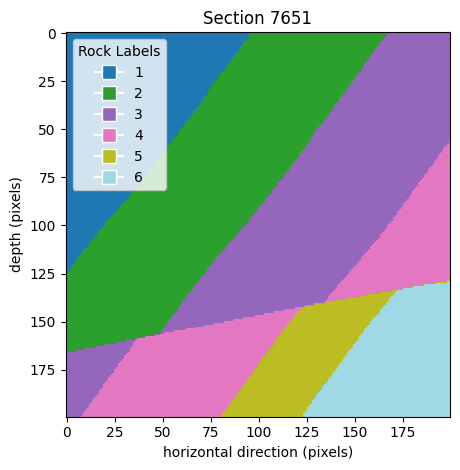

In [258]:
random_npz: int = random_gen.integers(0, nbr_npz - 1, 1)[0]
multi_array: np.ndarray[np.int8] = np.load(dataset_path / f"{random_npz}.npz")["arr_0"]
print(f"Selected file {random_npz}.npz")
section_id: int = random_gen.choice(multi_array.shape[0], 1)[0]
print(f"Selected section {section_id}")
section: np.ndarray[np.int8] = multi_array[section_id]

fig, ax = plt.subplots(1, 1)
class_color_map, norm, cmap_custom = create_colorbar(section)
sub_plot(ax, 0, section, f"Section {section_id}", class_color_map, cmap_custom, norm)
plt.tight_layout()
plt.show()

## Select a random number of electrode and a random pixel length
We want 2 pixels between each electrodes so we want $ \left(n_{electrodes} - 1\right) \times 2 $ pixels.

In [259]:
nbr_electrodes: int = random_gen.integers(24, 96, 1)[0]
print(f"{nbr_electrodes} electrodes")
pixel_length: np.float64 = random_gen.integers(1, 20, 1)[0] / 2
print(f"Pixel length: {pixel_length} m")
total_true_length: np.float64 = nbr_electrodes * pixel_length
print(f"Total true length: {total_true_length} m")
total_pixels_to_keep: int = (nbr_electrodes - 1) * 2
print(f"Total pixels to keep: {total_pixels_to_keep}")

74 electrodes
Pixel length: 6.0 m
Total true length: 444.0 m
Total pixels to keep: 146


We keep half of the horizontal length vertical pixels.

Sample shape: (73, 146)


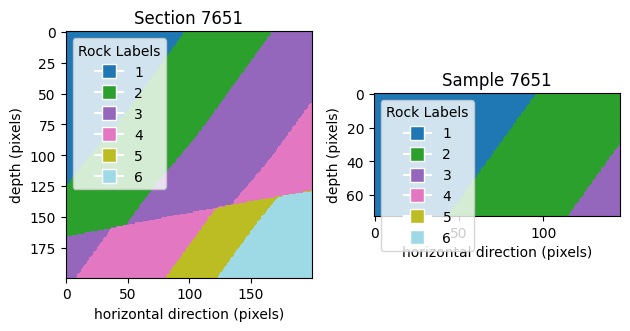

In [260]:
sample: np.ndarray[np.int8] = section[:total_pixels_to_keep // 2, :total_pixels_to_keep]
print(f"Sample shape: {sample.shape}")

fig, axes = plt.subplots(1, 2)
class_color_map, norm, cmap_custom = create_colorbar(section)
for idx, img in enumerate([section, sample]):
    sub_plot(axes, idx, img, f"Section {section_id}" if idx == 0 else f"Sample {section_id}", class_color_map, cmap_custom, norm)
plt.tight_layout()
plt.show()

## Resistivity assignation
We assign each rock class a random resistivity. The resistivity value is sampled from a uniform distribution on $ \left[0, 1\right] $ and mapped using a logarithm function to $ \left[2, 20000\right] $.

In [268]:
rock_classes: np.ndarray[np.int8] = np.unique(sample)
sample_log_res: np.ndarray[np.float64] = sample.astype(np.float64)
for rock_class in rock_classes:
    random_log_resistivity: np.float64 = random_gen.uniform(0, 1)
    print(f"Rock class {rock_class} with log resistivity {random_log_resistivity} (true resistivity is {detransform(random_log_resistivity)} ohm.m)")
    sample_log_res[sample == rock_class] = random_log_resistivity

Rock class 1 with log resistivity 0.9133220493285551 (true resistivity is 9001.568546765242 ohm.m)
Rock class 2 with log resistivity 0.5092409442638128 (true resistivity is 217.76785467366196 ohm.m)
Rock class 3 with log resistivity 0.2888013684111417 (true resistivity is 28.591403151145364 ohm.m)


Visualization:

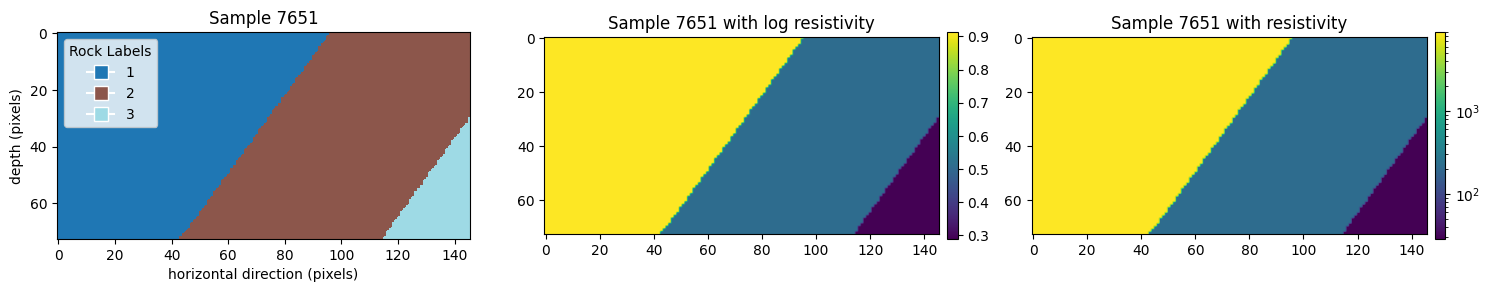

In [269]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))

class_color_map, norm, cmap_custom = create_colorbar(sample)
sub_plot(axes, 0, sample, f"Sample {section_id}", class_color_map, cmap_custom, norm)
img = axes[1].imshow(sample_log_res, cmap="viridis")
axes[1].set_title(f"Sample {section_id} with log resistivity")
fig.colorbar(img, ax=axes[1], orientation='vertical', fraction=0.025, pad=0.02)
img = axes[2].imshow(detransform(sample_log_res), cmap="viridis", norm=mcolors.LogNorm())
axes[2].set_title(f"Sample {section_id} with resistivity")
fig.colorbar(img, ax=axes[2], orientation='vertical', fraction=0.025, pad=0.02)
plt.tight_layout()
plt.show()

## pyGIMLi processing
First we create a grid with the same shape as the numpy array section. As the grid is described by its nodes but the numpy array is by its pixels, we need to have a grid that is total_pixels_to_keep + 1 large (number of pixels + the most right node).

(73, 146)


(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>,
 <matplotlib.colorbar.Colorbar at 0x1dc2d50aad0>)

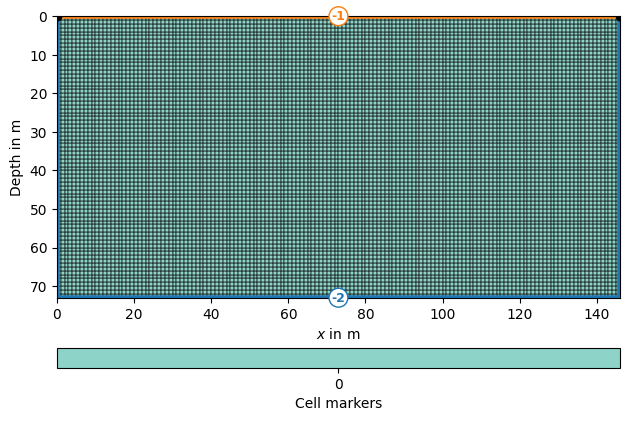

In [270]:
print(sample.shape)
x_arr: np.ndarray[np.float64] = np.linspace(0., total_pixels_to_keep, total_pixels_to_keep + 1, dtype=np.float64)
y_arr: np.ndarray[np.float64] = np.linspace(-(total_pixels_to_keep // 2), 0, total_pixels_to_keep // 2 + 1, dtype=np.float64)
world: pg.core.Mesh = pg.createGrid(x=x_arr, y=y_arr, worldBoundaryMarker=True)
pg.show(world, showMesh=True, markers=True)

Then, we place the electrodes on the nodes.

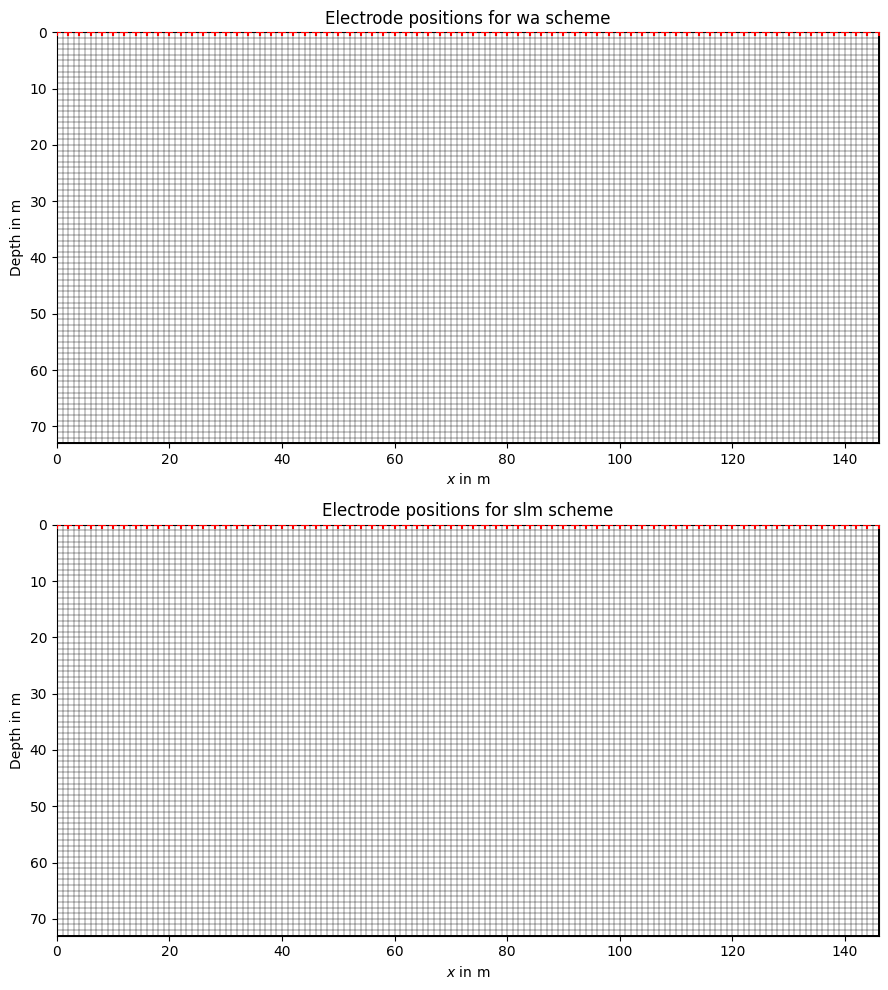

In [271]:
elec_array: np.float64 = np.linspace(0., total_pixels_to_keep, nbr_electrodes, dtype=np.float64)  # np.float64 to be compatible with C++ double
schemes: dict[str, pg.DataContainerERT] = {"wa": ert.createData(elecs=elec_array, schemeName='wa'), "slm": ert.createData(elecs=elec_array, schemeName='slm')}

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
for idx, (key, scheme) in enumerate(schemes.items()):
    pg.show(world, ax=axes[idx], showMesh=True)
    electrode_positions: np.ndarray[np.float64] = np.array([scheme.sensorPosition(i) for i in range(scheme.sensorCount())])
    axes[idx].scatter(electrode_positions[:, 0], electrode_positions[:, 1], marker='+', color='red', label='Electrodes', zorder=3)
    axes[idx].set_title(f"Electrode positions for {key} scheme")
plt.tight_layout()
plt.show()

This is the forward modelling step.

In [272]:
sample_res: np.ndarray[np.float64] = detransform(sample_log_res)
print(sample_res.ravel().shape)
print(world.cellCount())
result: dict[str, pg.DataContainerERT] = {electrode_scheme_name: ert.simulate(world, res=sample_res.ravel(), scheme=scheme, verbose=True) for electrode_scheme_name, scheme in schemes.items()}

(10658,)
10658


And the pseudosection can be viewed using:

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1dc3a859bd0>)

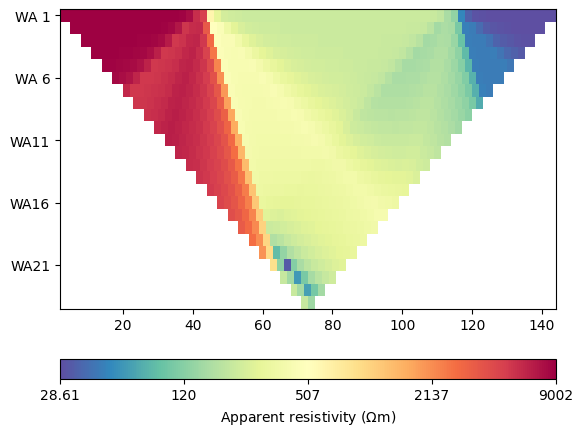

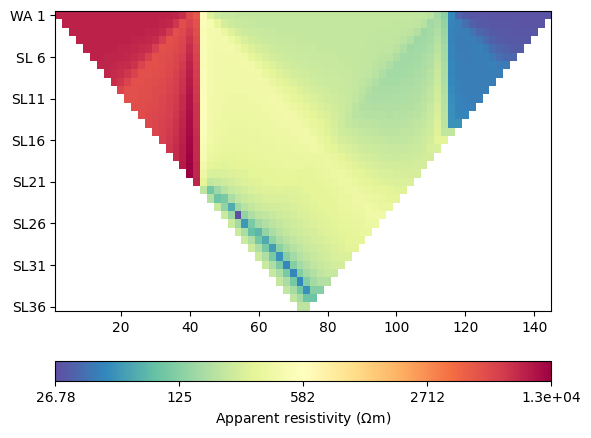

In [273]:
ert.showERTData(result["wa"])
ert.showERTData(result["slm"])

We can see what inversion is giving:

In [274]:
for electrode_scheme_name, scheme in schemes.items():
    result[electrode_scheme_name]["err"] = 0.001 * result[electrode_scheme_name]["rhoa"]
    pg.info('Filtered rhoa (min/max)', min(scheme['rhoa']), max(scheme['rhoa']))
mgr: dict[str, ert.ERTManager] = {electrode_scheme_name: ert.ERTManager(scheme) for electrode_scheme_name, scheme in result.items()}
inv: dict[str, pg.RVector] = {electrode_scheme_name: mgr[electrode_scheme_name].invert(lam=20, verbose=True, mesh=world) for electrode_scheme_name in mgr.keys()}

25/02/25 - 16:22:07 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.0 0.0
25/02/25 - 16:22:07 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.0 0.0
25/02/25 - 16:22:07 - pyGIMLi - INFO - Found 1 regions.
25/02/25 - 16:22:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
25/02/25 - 16:22:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
25/02/25 - 16:22:08 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 43071 Cells: 42632 Boundaries: 43070
25/02/25 - 16:22:09 - pyGIMLi - INFO - Use median(data values)=294.59294035716766
25/02/25 - 16:22:09 - pyGIMLi - INFO - Created startmodel from forward operator:10658, min/max=294.592940/294.592940
25/02/25 - 16:22:09 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001DC386A8860>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation: Logarithmic transform
min/max (data): 28.61/9002
min/max (error): 2.86%/900%
min/max (start model): 295/295
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  263.48
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    5.31 (dPhi = 97.47%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    0.78 (dPhi = 76.53%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.78)                   #
################################################################################


25/02/25 - 16:24:51 - pyGIMLi - INFO - Found 1 regions.
25/02/25 - 16:24:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
25/02/25 - 16:24:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
25/02/25 - 16:24:52 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 43071 Cells: 42632 Boundaries: 43070
25/02/25 - 16:24:52 - pyGIMLi - INFO - Use median(data values)=272.55903975518606
25/02/25 - 16:24:52 - pyGIMLi - INFO - Created startmodel from forward operator:10658, min/max=272.559040/272.559040
25/02/25 - 16:24:52 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001DC37633740>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation: Logarithmic transform
min/max (data): 26.78/1.3e+04
min/max (error): 2.68%/1264%
min/max (start model): 273/273
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  261.08
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   10.26 (dPhi = 95.70%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    2.41 (dPhi = 71.64%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.80 (dPhi = 19.58%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    1.83 (dPhi = -0.66%) lam: 20.0
#############################################

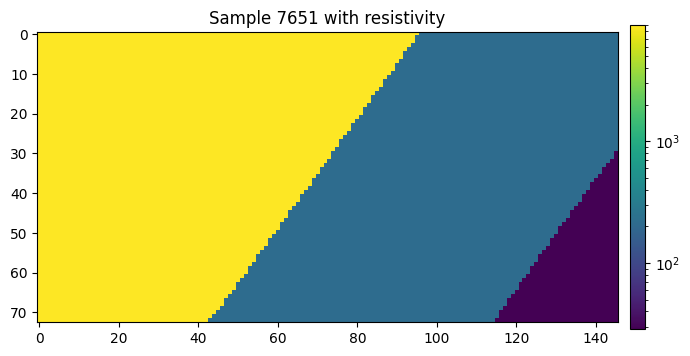

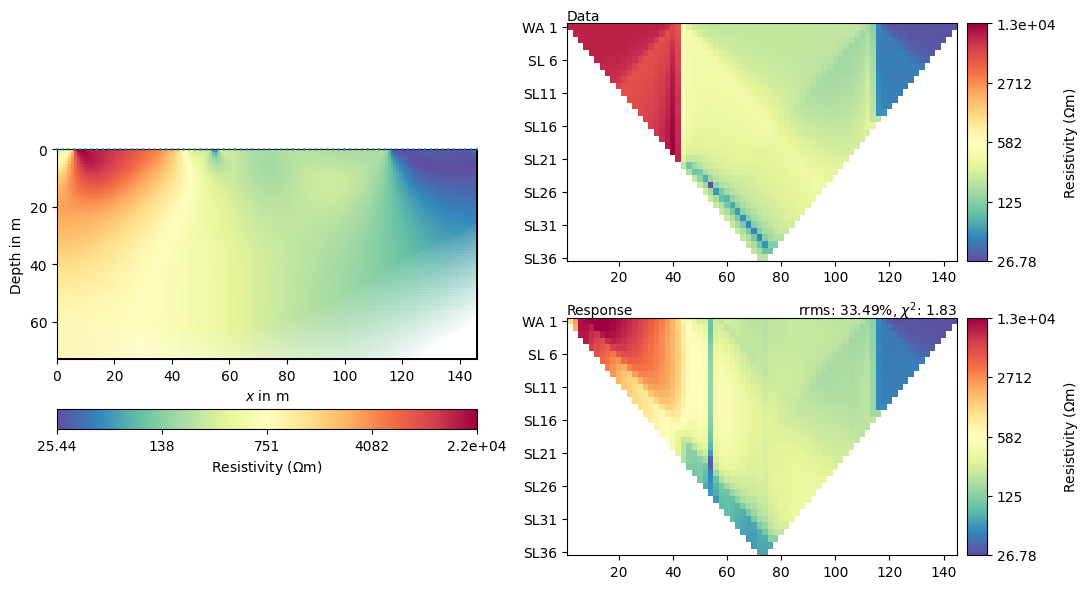

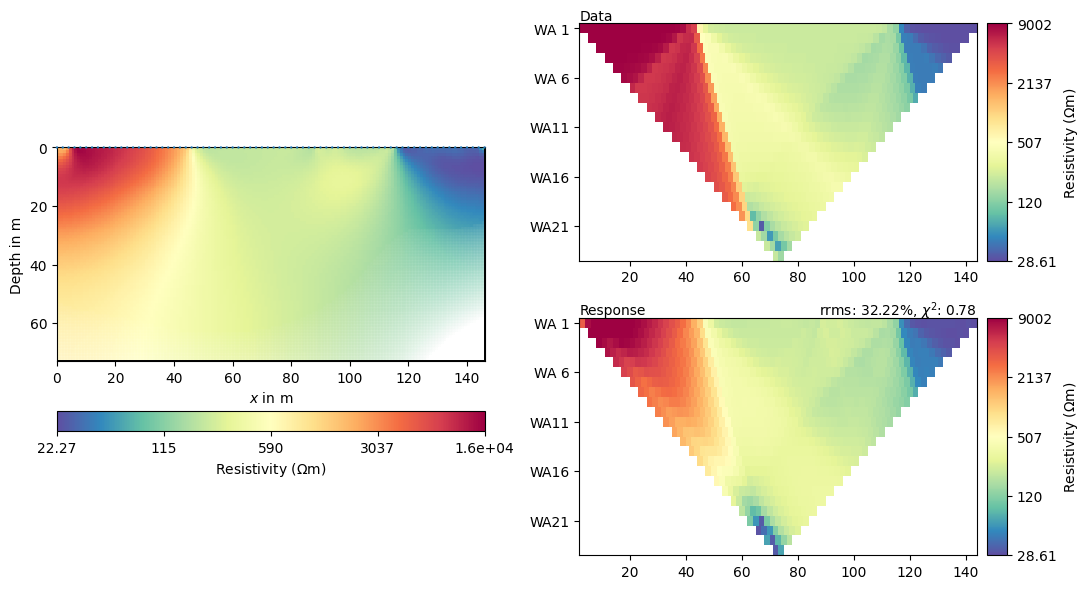

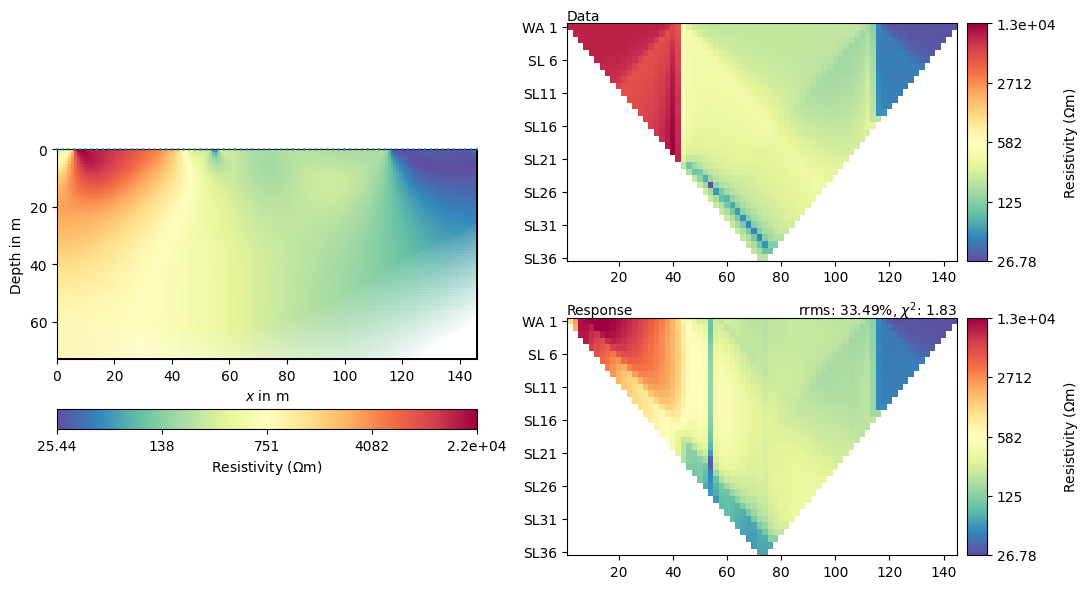

In [275]:
fig, ax = plt.subplots(figsize=(7, 5))
img = ax.imshow(detransform(sample_log_res), cmap="viridis", norm=mcolors.LogNorm())
ax.set_title(f"Sample {section_id} with resistivity")
fig.colorbar(img, ax=ax, orientation='vertical', fraction=0.025, pad=0.02)
plt.tight_layout()
plt.show()
mgr["wa"].showResultAndFit()
mgr["slm"].showResultAndFit()